In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
print(cv2.__version__)
import numpy as np

3.3.1


# Make uber pandas DF to store all x y tracks

In [2]:
path = "G:\My Drive\Moth Annotations\Tip Manual Digitization"
trackframe_filename = 'ManualTipTRacking_DigitizingChart.xlsx'
frameInfo = pd.read_excel(path + "\\" + trackframe_filename)
frameInfo.head()

,Name,Date,trial,Start,Frame Start,Digitized Start,Stop,Frame Stop,Digitized Stop
0,c-1_m13,2018-03-13,0,11:15:00,20070,20455,12:00:00,21600,21200
1,c-1_m13,2018-03-13,last,1900-01-01 16:25:00,72450,72930,1900-01-01 17:09:00,73962,73020
2,c-2_m5,2018-02-20,0,12:40:00,22320,22910,13:34:00,24012,23660
3,c-2_m5,2018-02-20,last,1900-01-01 11:10:00,63180,63540,1900-01-01 11:42:00,63756,63630
4,c-3_m10,2018-03-01,0,11:15:00,20070,20390,12:02:00,21636,21150


In [3]:
frameInfo.Name.unique()

array(['c-1_m13', 'c-2_m5', 'c-3_m10', 'c-10_m11'], dtype=object)

In [53]:
moth_Name = []
trial = []
x = []
y = []

for name in frameInfo.Name.unique():
    filepath = glob.glob(path + "\\" + "*" + name + "xypts.csv")
    xypts = pd.read_csv(filepath[0])
    
    Useful_frameInfo = frameInfo[frameInfo['Name'] == name]
    
    t0_start = Useful_frameInfo[Useful_frameInfo['trial']==0]['Digitized Start'].values[0]
    t0_stop = Useful_frameInfo[Useful_frameInfo['trial']== 0]['Digitized Stop'].values[0]
    
    trial0 = xypts.loc[t0_start:t0_stop,'pt4_cam1_X':'pt4_cam1_Y']
    
    N = [name] * len(trial0)
    t = ['0'] * len(trial0)
    
    moth_Name.extend(N)
    trial.extend(t)
    x.extend(trial0.pt4_cam1_X.values)
    y.extend(trial0.pt4_cam1_Y.values)
    
    
    tlast_start = Useful_frameInfo[Useful_frameInfo['trial']=='last']['Digitized Start'].values[0]
    tlast_stop = Useful_frameInfo[Useful_frameInfo['trial']== 'last']['Digitized Stop'].values[0]
    
    trial_last = xypts.loc[tlast_start:tlast_stop,'pt4_cam1_X':'pt4_cam1_Y']
    
    N = [name] * len(trial_last)
    t = ['last'] * len(trial_last)
    
    moth_Name.extend(N)
    trial.extend(t)
    x.extend(trial_last.pt4_cam1_X.values)
    y.extend(trial_last.pt4_cam1_Y.values)
    

uber_df = pd.DataFrame({'name': moth_Name, 'trial': trial, 'xpts': x, 'ypts': y}) 

In [55]:
uber_df.head()

,name,trial,xpts,ypts
0,c-1_m13,0,NaN,NaN
1,c-1_m13,0,5.011057,348.049824
2,c-1_m13,0,20.932432,335.463658
3,c-1_m13,0,40.568796,325.165885
4,c-1_m13,0,50.652334,323.449590


# Export background image and circle parameters for all moths

In [64]:
# get the bckgrnd Image and store it

pathForVideo = "G:\My Drive\Flower shape Experiment Data\RawVideoData"

for name in frameInfo.Name.unique():
    videopath = glob.glob(pathForVideo + "\**\\" + name + ".mp4", recursive=True)

    vid = cv2.VideoCapture(videopath[0])

    ret = vid.set(1,1)
    print(ret)

    ret, frame = vid.read(1)
    
    # write the frame
    
    cv2.imwrite('.\\dataFolders\\background_images\\' + name + '_bckgrnd_Img.png',frame)

True
True
True
True


In [65]:
# load image and get radius and center of image, save as separate csv file

def GetCircle(img):
    
#     from skimage import color
    from skimage.feature import canny
    from skimage.transform import hough_circle, hough_circle_peaks
    
    # img - input has to be a grayscale image
    blurred = cv2.GaussianBlur(img, (5,5), 0)
    # Get the edges
    edges = canny(blurred, sigma=5) 
    # perform the hough transform to get circles of radii close to 100
    hough_radii = np.arange(50, 150, 1)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1)
    return(cx[0], cy[0], radii[0])

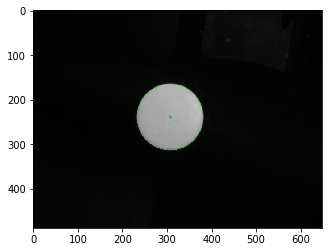

In [93]:
Name = []
circle_x= []
circle_y = []
circle_radius = []

for name in frameInfo.Name.unique():
    pathForImage = glob.glob('./dataFolders/background_images/'+ name + '*.png')
    img = cv2.imread(pathForImage[0],0)
    circ_x, circ_y, circ_radii = GetCircle(img)
    
    Name.extend([name])
    circle_x.extend([circ_x])
    circle_y.extend([circ_y])
    circle_radius.extend([circ_radii])

    # Draw the circle on the image to confirm you have the right thing

    from skimage.draw import circle_perimeter, circle
    from skimage import color
    
    bckgrnd_tmp = color.gray2rgb(img)
    circy, circx = circle_perimeter(circ_y, circ_x, circ_radii)
    bckgrnd_tmp[circ_y-2:circ_y+2, circ_x-2:circ_x+2] = (20, 220, 20)
    bckgrnd_tmp[circy, circx] = (20, 220, 20)
    cv2.imwrite('.\\dataFolders\\background_images\\' + name + '_DetectedCircle.png', bckgrnd_tmp)
    plt.imshow(bckgrnd_tmp, cmap='gray')

circle_params = pd.DataFrame({'name': Name, 'circ_x' : circle_x, 'circ_y': circle_y, 'circ_radii': circle_radius})
circle_params.to_csv('./dataFolders/circle_parameters.csv')

In [90]:
circle_params

,name,circ_x,circ_y,circ_radii
0,c-1_m13,308,240,76
1,c-2_m5,309,238,74
2,c-3_m10,308,239,74
3,c-10_m11,307,239,74


In [161]:
# center all the tracked points to the flower center and calculate r and theta and add to uber dataframe

radius = []
theta = []

for name in frameInfo.Name.unique():
    x = uber_df[uber_df.name == name].xpts.values
    y = uber_df[uber_df.name == name].ypts.values
    
    cent_x = circle_params[circle_params['name'] == name].circ_x.values[0]
    cent_y = circle_params[circle_params['name'] == name].circ_y.values[0]
    centered_x = x - cent_x
    centered_y = y - cent_y
    r = np.linalg.norm([centered_x, centered_y], axis = 0)
    radius.extend(r)
    
    angle = np.arctan2(centered_y,centered_x)*180/np.pi
    copy_theta = pd.Series(data = angle)
    range_theta  = copy_theta.where(copy_theta>0, copy_theta+360)
    theta.extend(range_theta)

In [163]:
uber_df.loc[:,'radius'] = pd.Series(data = radius, index=uber_df.index)
uber_df.loc[:,'theta'] = pd.Series(data = theta, index=uber_df.index)

In [166]:
uber_df.head()

,name,trial,xpts,ypts,radius,theta
0,c-1_m13,0,NaN,NaN,NaN,NaN
1,c-1_m13,0,5.011057,348.049824,321.678510,160.373100
2,c-1_m13,0,20.932432,335.463658,302.524542,161.605573
3,c-1_m13,0,40.568796,325.165885,280.664705,162.335453
4,c-1_m13,0,50.652334,323.449590,270.539563,162.033785


In [167]:
# export uber dataframe as csv

uber_df.to_csv('./dataFolders/compiledTrackData.csv')

# Draw the tracks on bckgrnd frame for all moths

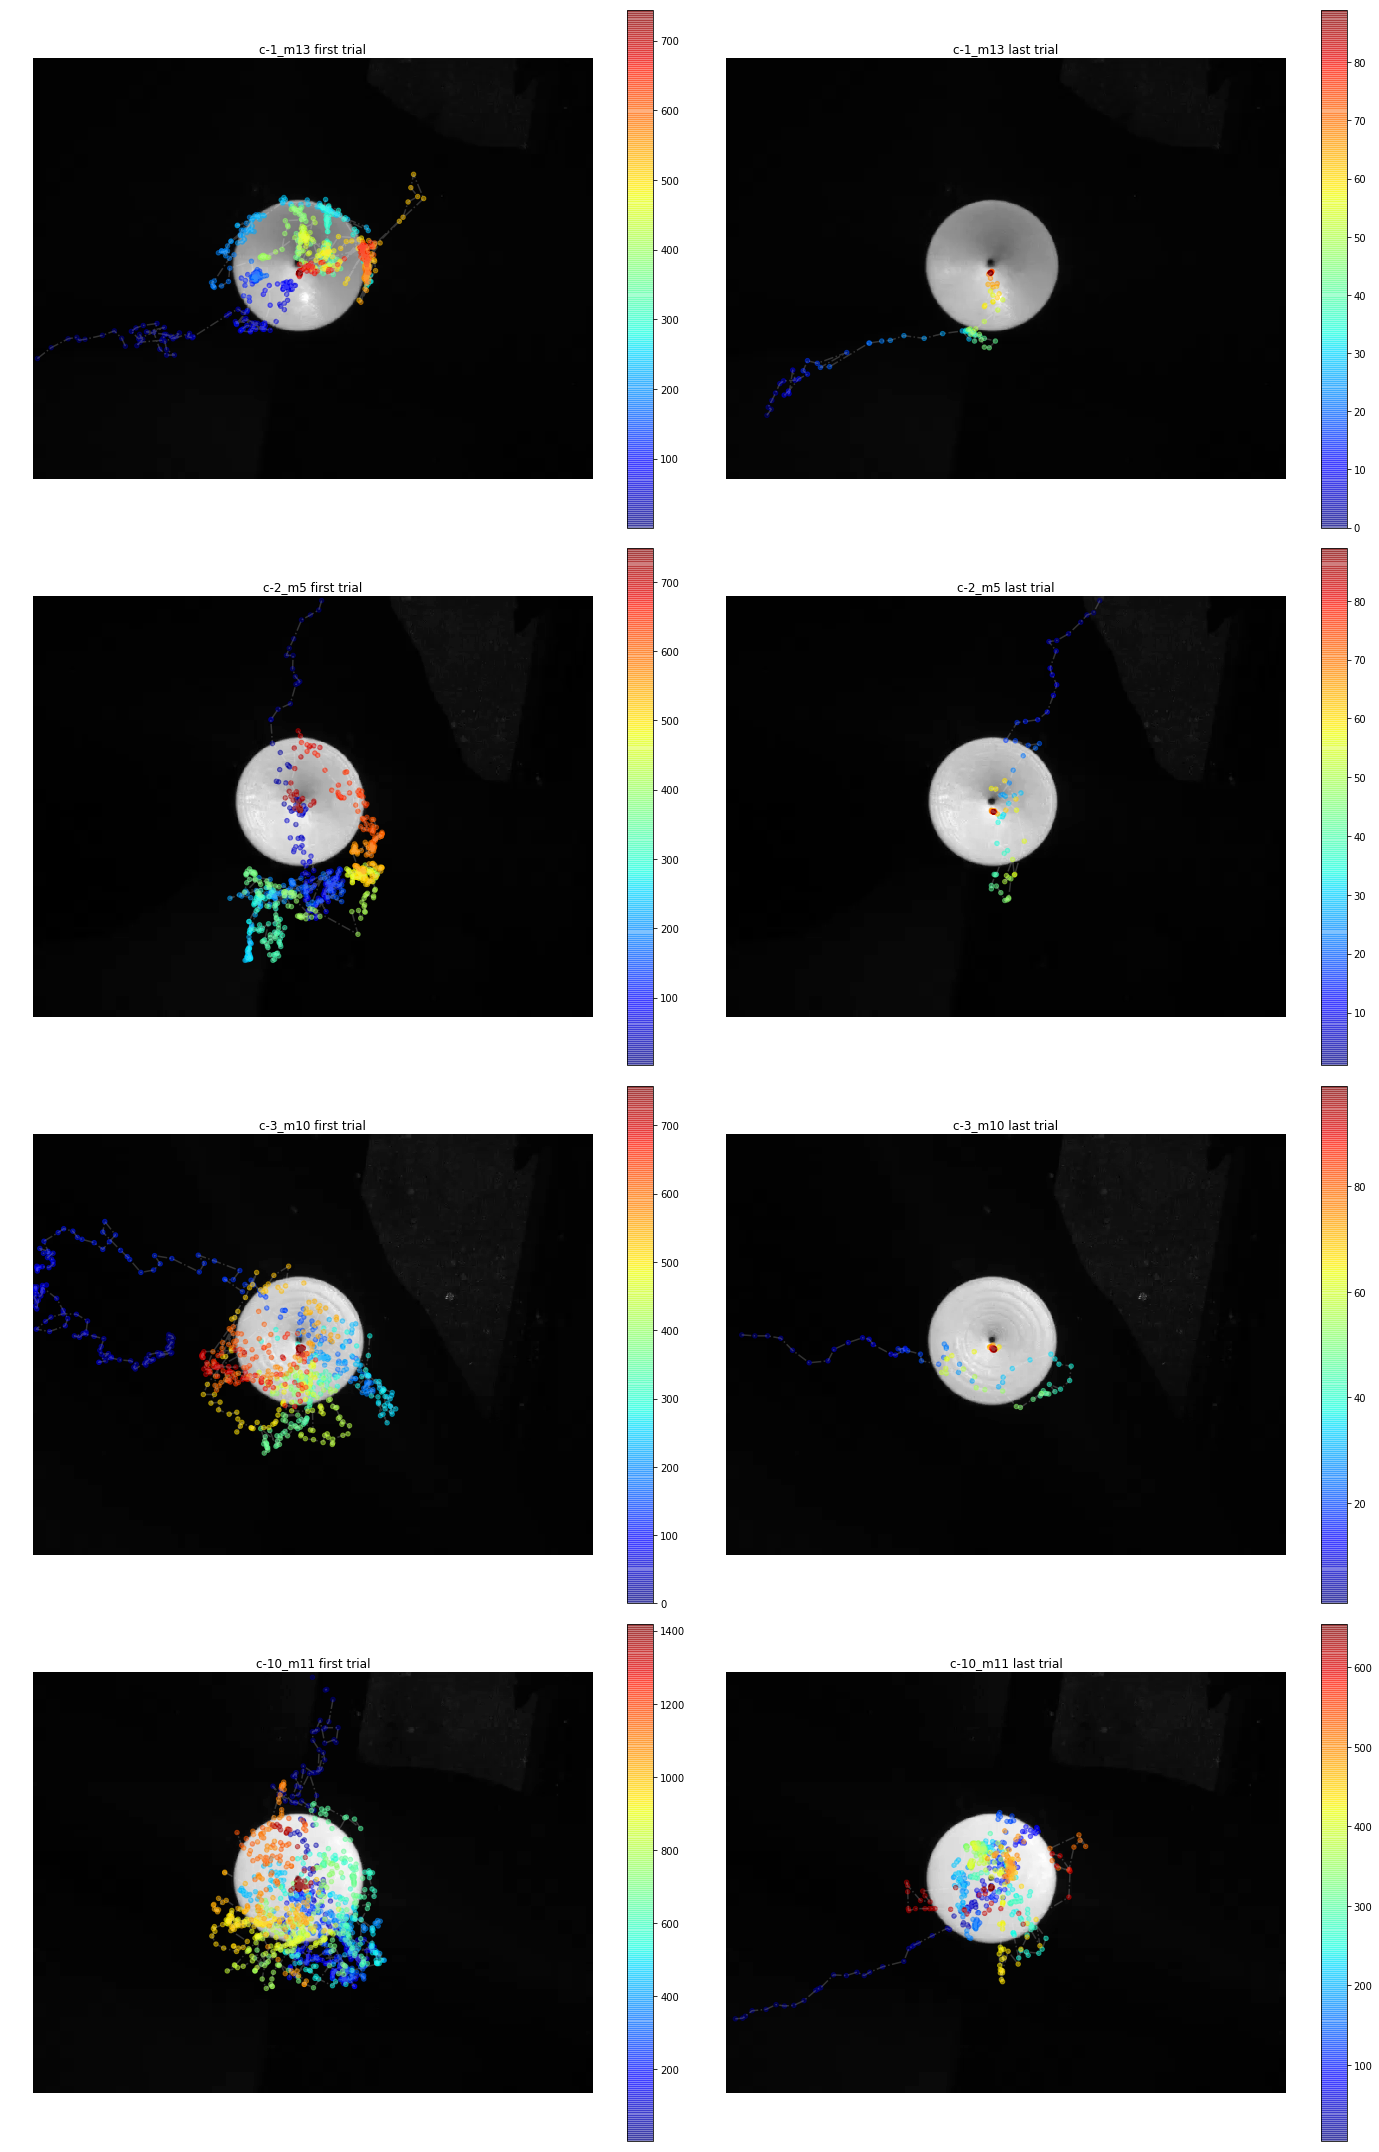

In [169]:
fig, ax = plt.subplots(4,2, figsize = (20,30))

for i,name in zip(range(len(ax)), frameInfo.Name.unique()):
    
    pathForImage = glob.glob('./dataFolders/background_images/'+ name + '*.png')
    img = cv2.imread(pathForImage[0],0)
    height, width = img.shape
    
    # get the x and y tracks
    x_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')].xpts.values
    y_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')].ypts.values
    
    x_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')].xpts.values
    y_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')].ypts.values
                  
    ax[i,0].imshow(img, 'gray')
    ax[i,1].imshow(img, 'gray')
                
    t0 = np.arange(len(x_first))
    f0 = ax[i,0].scatter(x_first, y_first,
                s= 20, alpha = 0.5, 
                c=t0, cmap = "jet")
    fig.colorbar(f0, ax= ax[i,0])
    ax[i,0].plot(x_first, y_first, '-.', c = "whitesmoke", alpha = 0.2)
    
    ax[i,0].set_xlim(0,width)
    ax[i,0].set_ylim(height, 0)
    ax[i,0].set_axis_off()
    ax[i,0].set_title(name + ' first trial')
                   
    tlast = np.arange(len(x_last))
    flast = ax[i,1].scatter(x_last, y_last,
                s= 20, alpha = 0.5, 
                c=tlast, cmap = "jet")
    fig.colorbar(flast, ax= ax[i,1])
    ax[i,1].plot(x_last, y_last, '-.', c = "whitesmoke", alpha = 0.2)
    
    ax[i,1].set_xlim(0,width)
    ax[i,1].set_ylim(height, 0)
    ax[i,1].set_axis_off()
    ax[i,1].set_title(name + ' last trial')
    
    plt.tight_layout()
    plt.savefig('./dataFolders/Figures/TracksVisualization.png')

# Draw radius as function of time

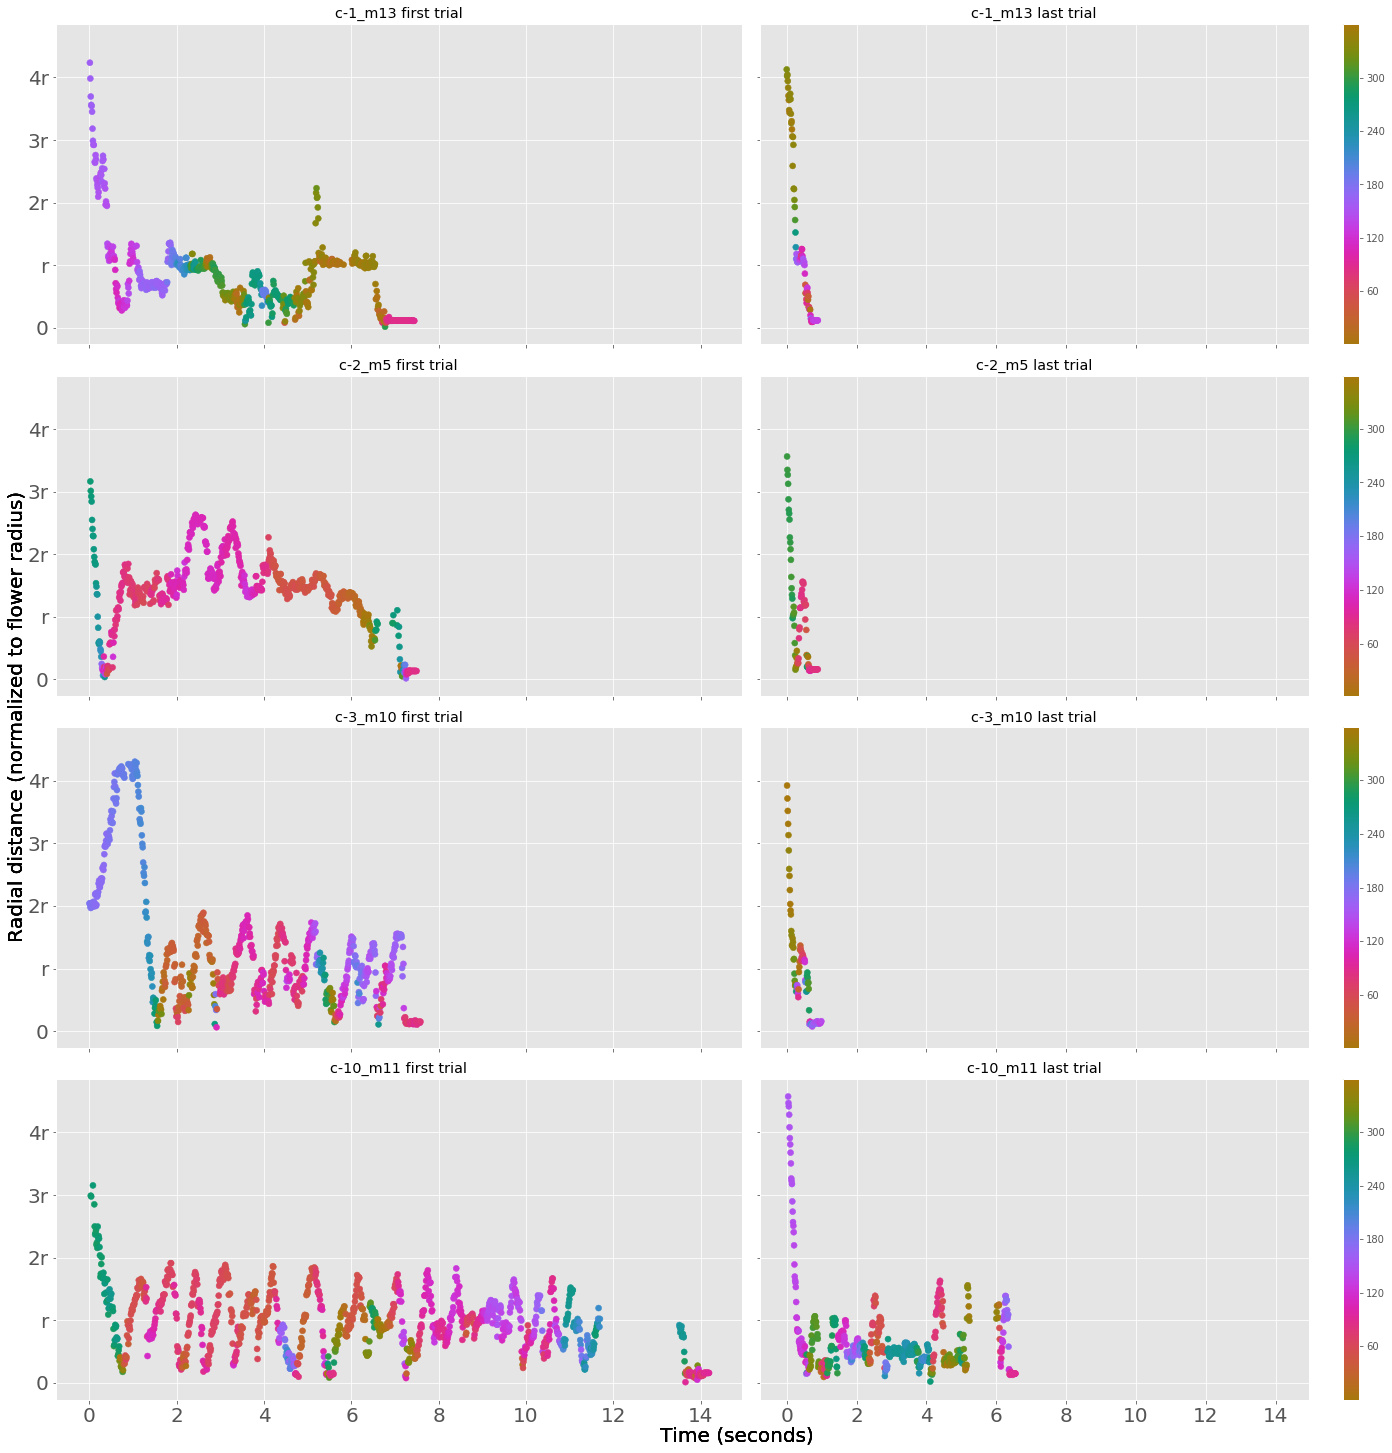

In [241]:
import cmocean
plt.style.use('ggplot')
fig, ax = plt.subplots(4,2, sharex = True, sharey = True, figsize = (20,20))

for i,name in zip(range(len(ax)), frameInfo.Name.unique()):
    
    # get the radius and theta tracks
    radius_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')].radius.values
    theta_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')].theta.values
    
    radius_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')].radius.values
    theta_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')].theta.values
    
    radius = circle_params[circle_params.name == name].circ_radii.values[0]
    
    # draw it NOW! :D (hehehehahahaha!!! :D )
   
    t0 = np.arange(len(radius_first))*1/100
    f0 = ax[i,0].scatter(t0, radius_first/radius, c = theta_first, cmap = cmocean.cm.phase)
    cbar = fig.colorbar(f0, ax = ax[i,1], ticks=[np.arange(0, 360, 60)])
    ax[i,0].set_title(name + ' first trial')
                   
    tlast = np.arange(len(radius_last))*1/100
    ax[i,1].scatter(tlast, radius_last/radius, c = theta_last, cmap = cmocean.cm.phase)
    ax[i,1].set_title(name + ' last trial')
    
    ax[i,0].set_yticks(np.arange(5))
    ax[i,0].set_yticklabels(['0', 'r', '2r', '3r', '4r'])
    ax[i,0].tick_params('both', labelsize = 20)
    ax[i,1].tick_params('both', labelsize = 20)
    
    fig.text(0.0, 0.5, 'Radial distance (normalized to flower radius)',
             ha='center', va='center', rotation='vertical', fontsize = '20')
    fig.text(0.5, 0.0, 'Time (seconds)',
             ha='center', va='center', rotation='horizontal', fontsize = '20')
    plt.tight_layout()
    plt.savefig('./dataFolders/Figures/RadialDistOverTime.png')

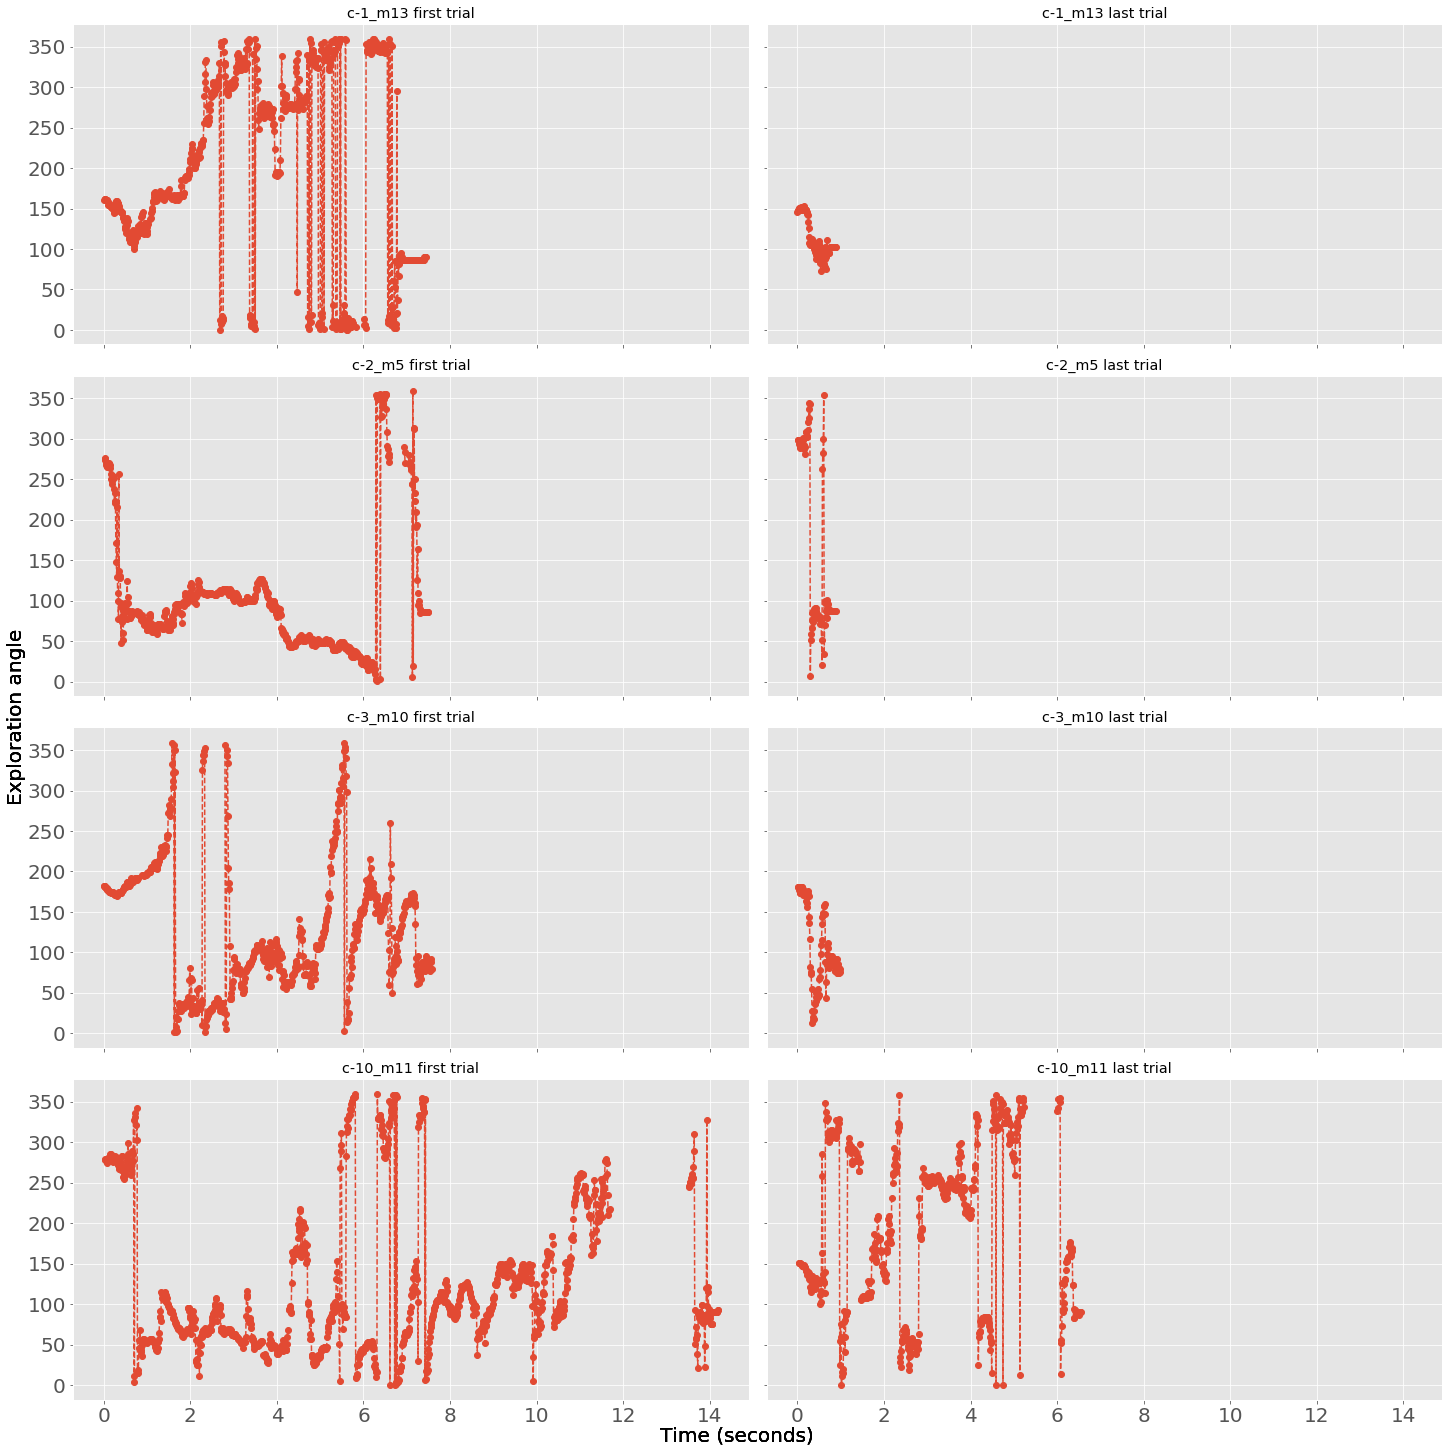

In [234]:
plt.style.use('ggplot')
fig, ax = plt.subplots(4,2, sharex = True, sharey = True, figsize = (20,20))

for i,name in zip(range(len(ax)), frameInfo.Name.unique()):
    
    # get the radius and theta tracks
    theta_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')].theta.values
    
    theta_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')].theta.values
    
    # draw it NOW! :D (hehehehahahaha!!! :D )
   
    t0 = np.arange(len(theta_first))*1/100
    ax[i,0].plot(t0, theta_first, marker = "o", 
               linestyle = "--")
    
    ax[i,0].set_title(name + ' first trial')
                   
    tlast = np.arange(len(theta_last))*1/100
    ax[i,1].plot(tlast, theta_last, marker = "o", 
               linestyle = "--")
    ax[i,1].set_title(name + ' last trial')
    
#     ax[i,0].set_yticks(np.arange(5))
#     ax[i,0].set_yticklabels(['0', 'r', '2r', '3r', '4r'])
    ax[i,0].tick_params('both', labelsize = 20)
    ax[i,1].tick_params('both', labelsize = 20)
    
    fig.text(0.0, 0.5, 'Exploration angle',
             ha='center', va='center', rotation='vertical', fontsize = '20')
    fig.text(0.5, 0.0, 'Time (seconds)',
             ha='center', va='center', rotation='horizontal', fontsize = '20')
    plt.tight_layout()
    plt.savefig('./dataFolders/Figures/ThetaOverTime.png')

# Draw the histograms

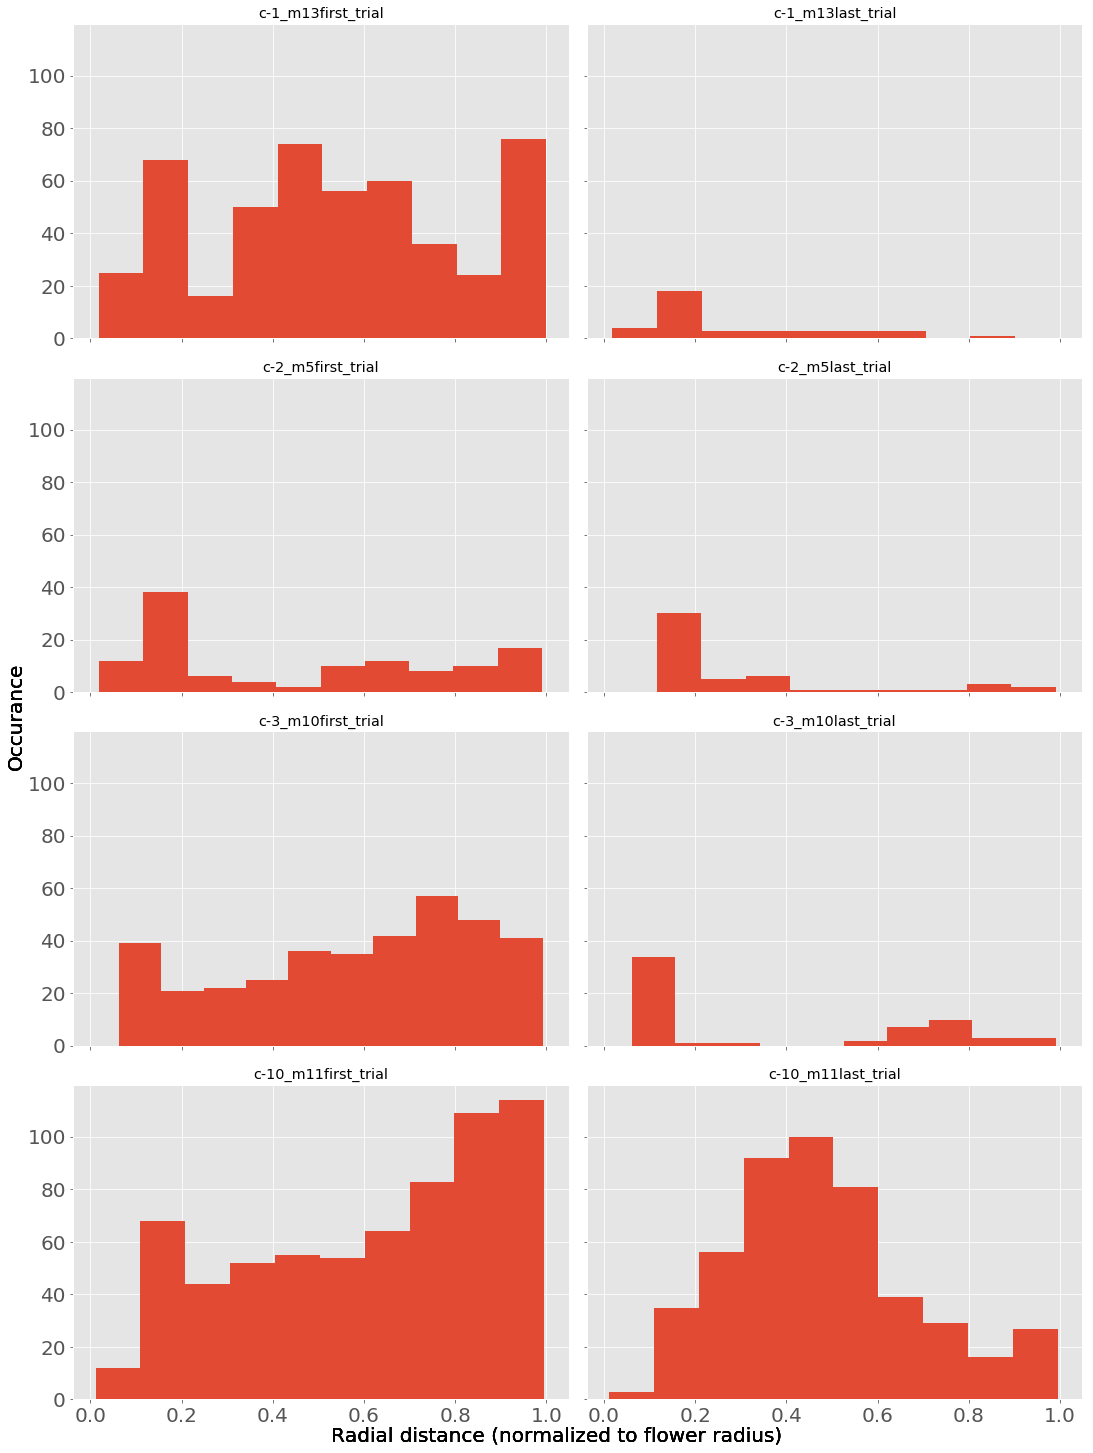

In [247]:
plt.style.use('ggplot')
fig, ax = plt.subplots(4,2, sharex = True, sharey = True, figsize = (15,20))

for i,name in zip(range(len(ax)), frameInfo.Name.unique()):

    # get the radius and theta tracks
    radius_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')].radius.values
    useful_r_first = radius_first[~np.isnan(radius_first)]
    R = circle_params[circle_params.name == name].circ_radii.values[0]
    useful_r_first = useful_r_first[useful_r_first <= R]
    
    radius_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')].radius.values
    useful_r_last = radius_last[~np.isnan(radius_last)]
    useful_r_last = useful_r_last[useful_r_last <= R]

#     fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (20,6))

    _,bins,_ = ax[i,0].hist(useful_r_first/R)
    ax[i,0].set_title(name + 'first_trial')
    ax[i,1].hist(useful_r_last/R, bins = bins)
    ax[i,1].set_title(name + 'last_trial')
    
    ax[i,0].tick_params('both', labelsize = 20)
    ax[i,1].tick_params('both', labelsize = 20)
    
    fig.text(0.0, 0.5, 'Occurance',
             ha='center', va='center', rotation='vertical', fontsize = '20')
    fig.text(0.5, 0.0, 'Radial distance (normalized to flower radius)',
             ha='center', va='center', rotation='horizontal', fontsize = '20')
    plt.tight_layout()
    plt.savefig('./dataFolders/Figures/RadialDistanceHistorgram.png')
    

# Draw the histogram for angle

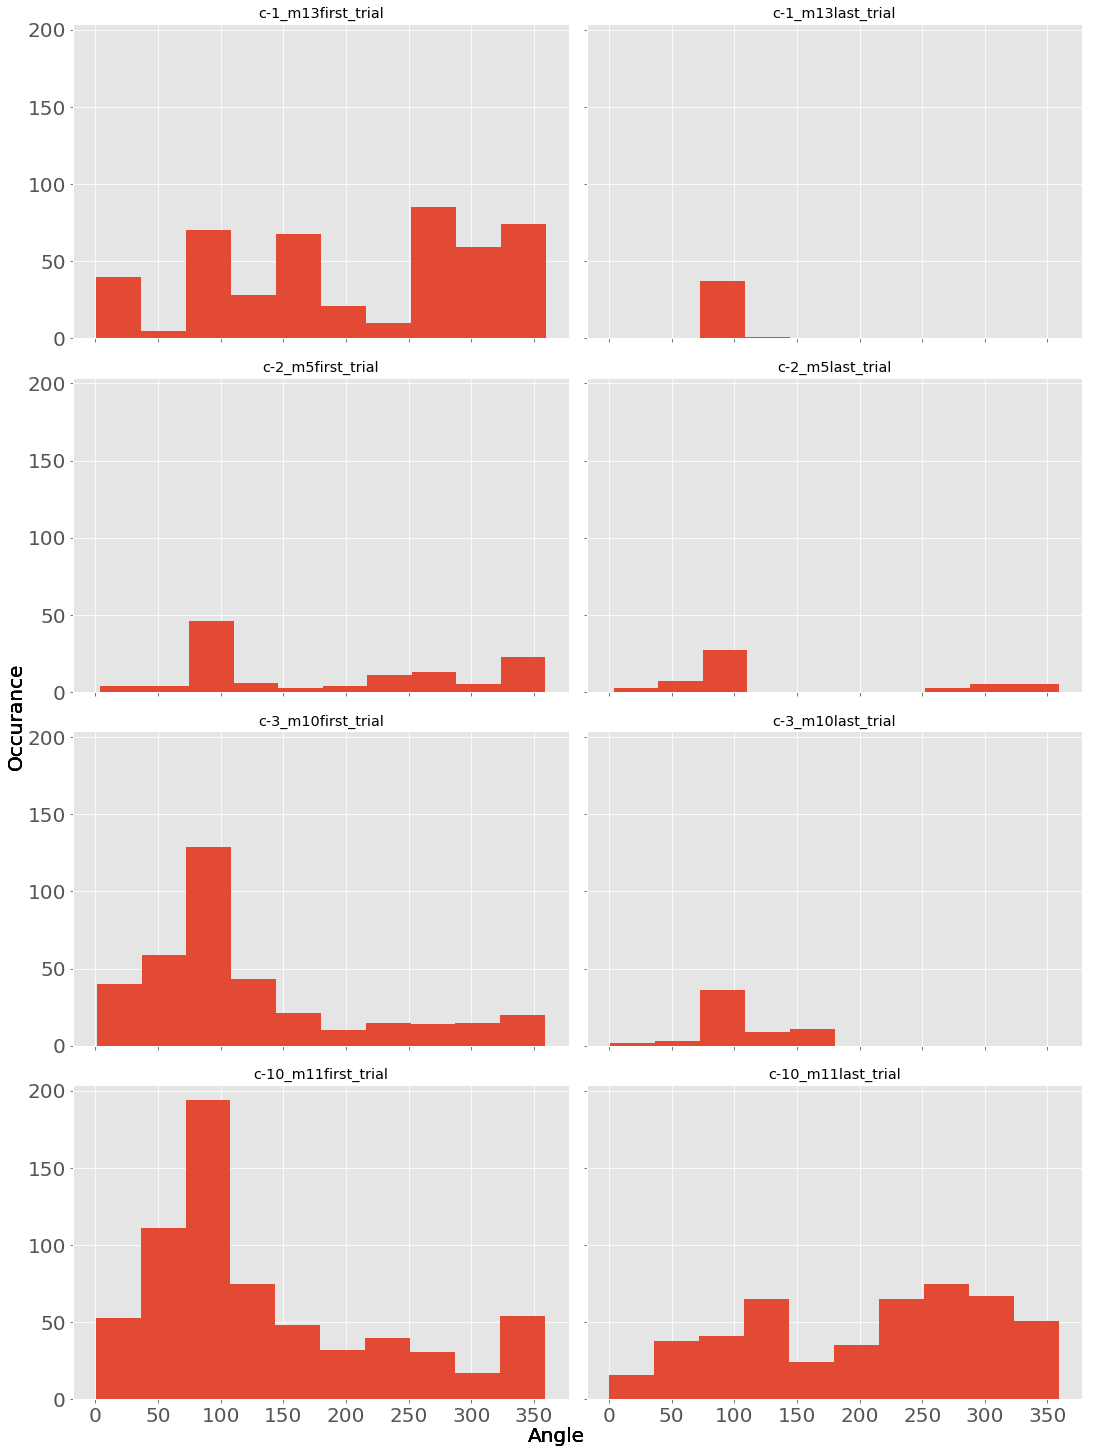

In [246]:
plt.style.use('ggplot')
fig, ax = plt.subplots(4,2, sharex = True, sharey = True, figsize = (15,20))

for i,name in zip(range(len(ax)), frameInfo.Name.unique()):

    # get the radius and theta tracks
    useful_first = uber_df[(uber_df.name == name) & (uber_df.trial == '0')]
    useful_first = useful_first[useful_first.radius <= R]
    theta_first = useful_first.theta.values
    hist_theta_first = theta_first[~np.isnan(theta_first)]
    
    useful_last = uber_df[(uber_df.name == name) & (uber_df.trial == 'last')]
    useful_last = useful_last[useful_last.radius <= R]
    theta_last = useful_last.theta.values
    hist_theta_last = theta_last[~np.isnan(theta_last)]
    
#     _,bins,_=plt.hist(hist_theta_first)
    _,bins,_ = ax[i,0].hist(hist_theta_first)
    ax[i,0].set_title(name + 'first_trial')
    ax[i,1].hist(hist_theta_last, bins = bins)
    ax[i,1].set_title(name + 'last_trial')
    
    ax[i,0].tick_params('both', labelsize = 20)
    ax[i,1].tick_params('both', labelsize = 20)
    
    fig.text(0.0, 0.5, 'Occurance',
             ha='center', va='center', rotation='vertical', fontsize = '20')
    fig.text(0.5, 0.0, 'Angle',
             ha='center', va='center', rotation='horizontal', fontsize = '20')
    plt.tight_layout()
    plt.savefig('./dataFolders/Figures/ThetaHistorgram.png')